In [ ]:
%load_ext autoreload
%autoreload 2


import modish
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure3_modalities_functional'

import flotilla

study = flotilla.embark('singlecell_pnm_figure2_modalities')
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))


## Overlap of modalities between celltypes

### Venn Diagrams

In [ ]:
import matplotlib_venn

for modality, df in study.supplemental.modalities_tidy.groupby('modality'):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    grouped = df.groupby('phenotype')
    events = [set(grouped.get_group(p).event_name) if p in grouped.groups else set([]) for p in study.phenotype_order]
    labels = study.phenotype_order
    colors = [study.phenotype_to_color[x] for x in labels]
    matplotlib_venn.venn3(events, set_labels=labels, set_colors=colors, ax=ax)
    ax.set_title(modality)
    fig.savefig('{}/modalities_venn_{}.pdf'.format(folder, modality))

### Heatmap of transitions from one celltype to the next

In [ ]:
import collections
import matplotlib as mpl
from scipy.stats import fisher_exact
import colorsys
from modish import MODALITY_ORDER, MODALITY_TO_COLOR


modality_subset = ['~0', 'bimodal', '~1']

grouped = study.supplemental.modalities_tidy.groupby('phenotype')

phenotype_transitions = study.phenotype_transitions + [('iPSC', 'MN')]

for phenotype1, phenotype2 in phenotype_transitions:
    modality_transitions = pd.DataFrame(0, index=MODALITY_ORDER, 
                                        columns=MODALITY_ORDER)
    modality_transitions.index.name = phenotype1
    modality_transitions.columns.name = phenotype2
    
    phenotypes = (phenotype1, phenotype2)
    
    df = pd.concat([grouped.get_group(phenotype1), grouped.get_group(phenotype2)])
    df = df.set_index('phenotype')
    df = df.dropna()
    df = df.groupby('event_name').filter(lambda x: len(x) == 2)
    
    for event_name, df2 in df.groupby('event_name'):
            modality1 = df2.ix[phenotype1].modality
            modality2 = df2.ix[phenotype2].modality
            modality_transitions.ix[modality1, modality2] += 1
    modality_sizes = modality_transitions.sum(axis=1)
    modality_transitions = modality_transitions.reindex(index=MODALITY_ORDER, columns=MODALITY_ORDER)
    percentages = 100*modality_transitions.divide(modality_sizes,axis=0)
    
    # Only use a few of the modalities we're interested in
    percentages = percentages.loc[modality_subset, modality_subset]
    modality_transitions = modality_transitions.loc[modality_subset, modality_subset]
    
    # Anything that's zero will be whited out
    mask = percentages == 0
    
    # Plot the figure
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(percentages, cbar_kws={'label': 'Percentage of events in {}'.format(phenotype1)}, annot=False,
                vmin=0, vmax=100, linewidth=1, ax=ax, mask=mask)
    for ytl in ax.get_yticklabels():
        ytl.set(rotation=0)
    for xtl in ax.get_xticklabels():
        xtl.set(rotation=90)
        
    # Modification of seaborn's heatmap annotator
    """Add textual labels with the value in each cell."""
    values = modality_transitions.ix[::-1].values
    mesh = ax.collections[0]
    xpos, ypos = np.meshgrid(ax.get_xticks(), ax.get_yticks())
    for x, y, val, color in zip(xpos.flat, ypos.flat,
                                values.flat, mesh.get_facecolors()):
        if val is not np.ma.masked:
            _, l, _ = colorsys.rgb_to_hls(*color[:3])
            text_color = ".15" if l > .5 else "w"
            val = ("{:g}").format(val)
            ax.text(x, y, val, color=text_color,
                    ha="center", va="center", fontsize=12)
    fig.tight_layout()
    pdf = '{}/modality_transitions_{}_to_{}_heatmap.pdf'.format(folder, phenotype1, phenotype2)
    print pdf
    fig.savefig(pdf)

### Stacked violinplots of modaliteis

#### Get modality categories across celltypes

In [12]:
import collections

modalities_all_celltypes_index = study.supplemental.modalities_tidy.set_index('phenotype')

modality_across_celltypes = modalities_all_celltypes_index.groupby('event_name', as_index=True, group_keys=False).apply(
    lambda x: ','.join(x.modality[study.phenotype_order]))
modality_across_celltypes.head()

event_name
chr10:101476219-101480743:-|3p    ~0,bimodal,~0
chr10:101476219-101480743:-|5p    ~0,bimodal,~0
chr10:101478258-101480743:-|3p    ~1,bimodal,~1
chr10:101478258-101480743:-|5p    ~1,bimodal,~1
chr10:101486829-101487197:-|3p         ~0,~0,~0
dtype: object

In [13]:
singles_no_outliers_ids = study.splicing.singles.index.difference(study.splicing.outliers.index)

In [14]:
modality_across_celltypes = modality_across_celltypes.str.strip(',')

### Make BED files of modality trios across celltypes

In [15]:
# %%time 
# import pybedtools

# bed_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/'

# DIR = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

# # upstream400 = pybedtools.BedTool('{}/se_mxe_alt_exon_upstream400.bed'.format(DIR))
# # downstream400 = pybedtools.BedTool('{}/se_mxe_alt_exon_downstream400.bed'.format(DIR))e
# exon_5p = pybedtools.BedTool('{}/exon_5p.bed'.format(DIR))
# exon_3p = pybedtools.BedTool('{}/exon_3p.bed'.format(DIR))

# background_events = set(modality_across_celltypes.index)

# exons = {'exon_5p': exon_5p, 'exon_3p': exon_3p}

# for modality_trio, series in modality_across_celltypes.groupby(modality_across_celltypes):
#     event_names = set(series.index)
#     print '\n', modality_trio
#     for name, bed in exons.items():
#         filtered_bed = bed.filter(lambda x: x.name in event_names)
#         filtered_filename = '{}/{}_exonbody_{}.bed'.format(bed_folder, name, modality_trio)
#         filtered_bed.saveas(filtered_filename)
        
#         background_bed = bed.filter(lambda x: x.name not in event_names and x.name in background_events)
#         background_filename = '{}/{}_exonbody_{}_background.bed'.format(bed_folder, name, modality_trio)
#         background_bed.saveas(background_filename)

#         ! wc -l $filtered_filename
#         ! wc -l $background_filename

### Make stacked violinplots of modalities

In [16]:

# import matplotlib as mpl

# for modalities, s in modality_across_celltypes.groupby(modality_across_celltypes):
#     print modalities, s.shape
    
#     fig, ax = plt.subplots(figsize=(2.5, 2.5))
    
#     if s.shape[0] <= 100:
#         events = s.index
#     else:
#         events = np.random.choice(s.index, size=100, replace=False)
#     modalities_split = modalities.split(',')
#     color = [modality_colors[x] for x in modalities_split]
    
#     for event in events:
#         try:
#             study.splicing._violinplot(event, phenotype_groupby=study.sample_id_to_phenotype,
#                                        sample_ids=singles_no_outliers_ids, stripplot=False, get_pooled=False,
#                                       phenotype_order=study.phenotype_order, ax=ax, color=color,
#                                       bw=0.2, ylim=(0, 1), yticks=(0, 0.5, 1), ylabel='$\Psi$')
#         except ValueError:
#             continue
            
#     ax.set(title='', xticklabels=study.phenotype_order, xlabel='')
#     sns.despine()
#     alpha = max(1./(len(events)+1.), 0.1)
    
#     # Add transparency
#     polycollections = [x for x in ax.collections if isinstance(x, mpl.collections.PolyCollection)]
#     for polycollection in polycollections:
#         polycollection.set_alpha(alpha)
#     fig.tight_layout()
#     fig.savefig('{}/stacked_violinplots_{}.pdf'.format(folder, modalities))

## GO enrichment

In [17]:
modality_group_sizes = modality_across_celltypes.groupby(modality_across_celltypes).size()
modality_group_sizes.sort(ascending=False)
modality_group_sizes

~0,~0,~0                     10263
~1,~1,~1                      7405
bimodal,bimodal,bimodal       1376
~0,~0,bimodal                  819
bimodal,~0,~0                  803
~1,~1,bimodal                  702
~1,bimodal,bimodal             378
~0,bimodal,~0                  276
bimodal,bimodal,~0             259
~0,bimodal,bimodal             242
bimodal,~0,bimodal             239
~1,bimodal,~1                  217
bimodal,~1,~1                  131
bimodal,bimodal,~1              99
bimodal,~1,bimodal              89
ambiguous,bimodal,bimodal       34
~0,bimodal,~1                   11
~0,~0,~1                         8
~1,~1,~0                         7
~1,bimodal,~0                    7
ambiguous,bimodal,~0             4
middle,bimodal,bimodal           2
~0,~1,~1                         2
~1,ambiguous,bimodal             2
~1,~0,~0                         2
ambiguous,bimodal,~1             2
~0,ambiguous,bimodal             2
middle,~1,bimodal                1
bimodal,~0,~1       

In [19]:
study.splicing.feature_expression_id_col = 'ensembl_id'

ambiguous,bimodal,bimodal (34,)
                              features_of_interest_in_go_term  \
GO:0005654  ENSG00000170144,ENSG00000141552,ENSG0000008523...   
GO:0005634  ENSG00000170144,ENSG00000151500,ENSG0000016971...   
GO:0003676  ENSG00000169714,ENSG00000125944,ENSG0000017014...   
GO:0005515  ENSG00000123562,ENSG00000112514,ENSG0000014155...   
GO:0000166  ENSG00000125944,ENSG00000170144,ENSG0000013875...   

                 features_of_interest_in_go_term_gene_symbols  \
GO:0005654     HNRNPA3,ANAPC11,TAF9,HNRNPR,HNRNPD,TCEB1,NOLC1   
GO:0005634  HNRNPA3,THYN1,CNBP,ACP1,TAF9,HNRNPR,MORF4L2,RP...   
GO:0003676                   CNBP,HNRNPR,HNRNPA3,G3BP2,HNRNPD   
GO:0005515  MORF4L2,CUTA,ANAPC11,ACP1,TAF9,HNRNPR,HNRNPD,T...   
GO:0000166                        HNRNPR,HNRNPA3,G3BP2,HNRNPD   

                     go_domain               go_name  n_background_in_go_term  \
GO:0005654  cellular_component           nucleoplasm                      195   
GO:0005634  cellular_com

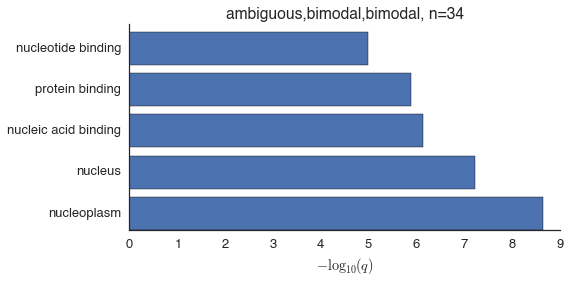

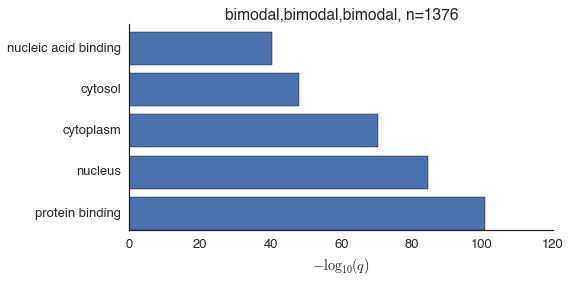

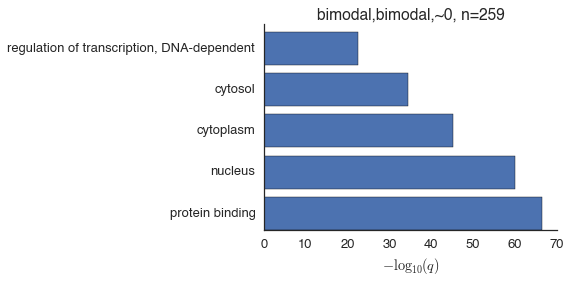

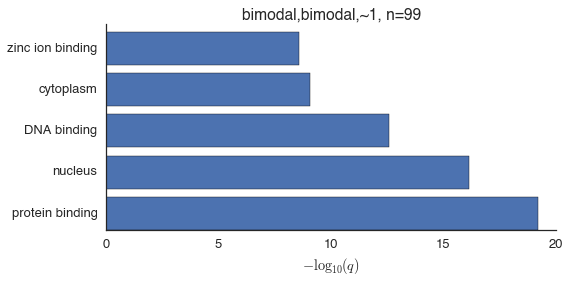

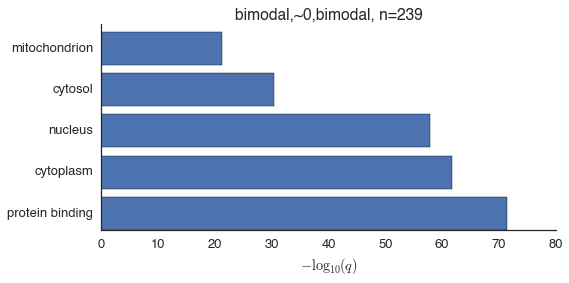

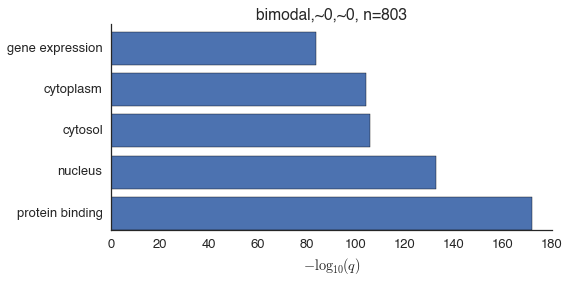

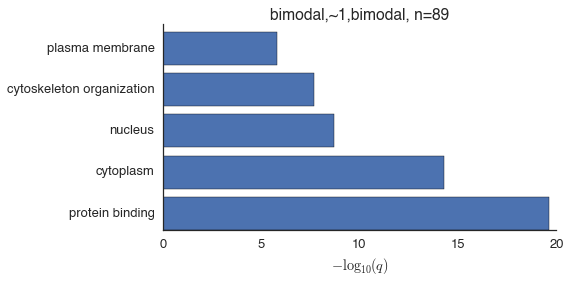

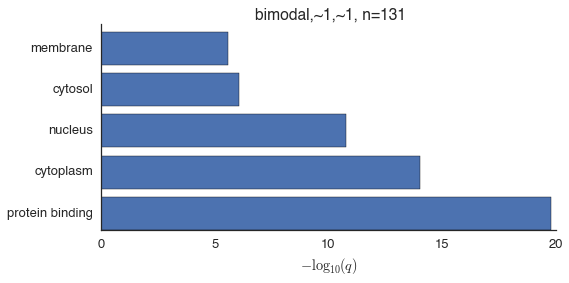

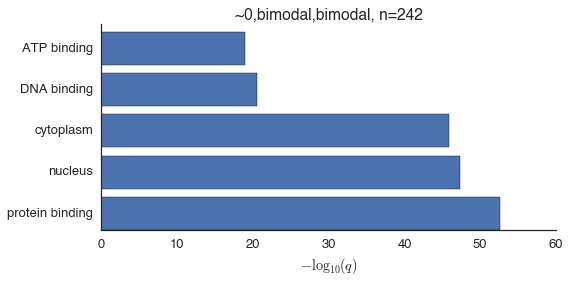

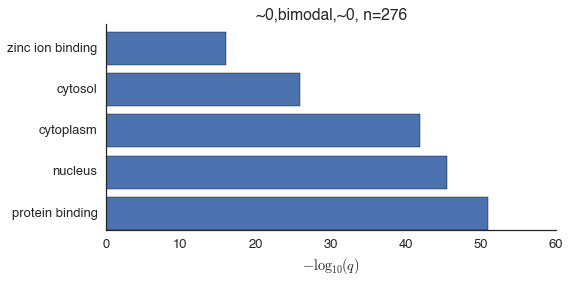

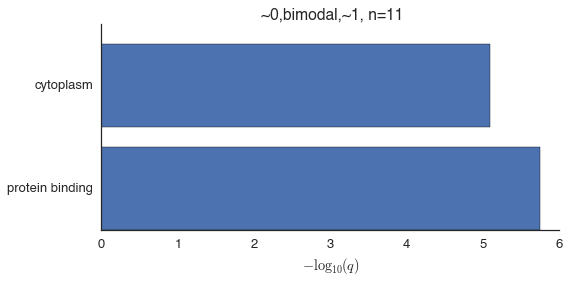

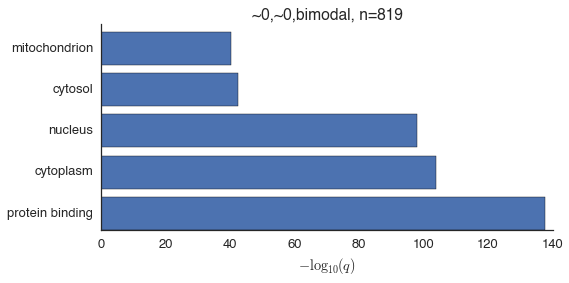

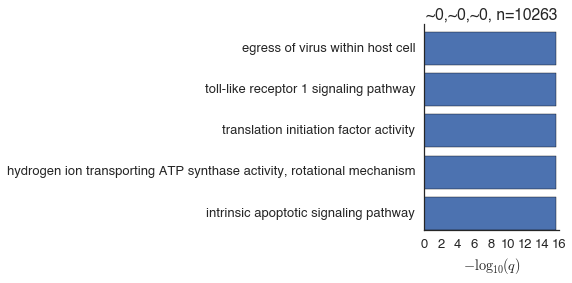

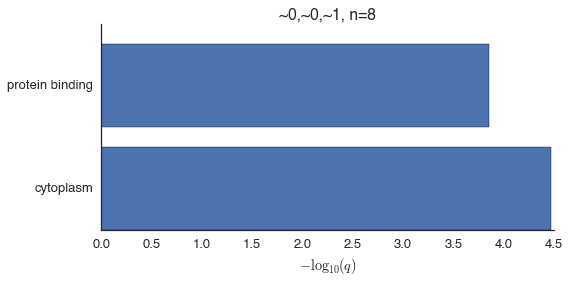

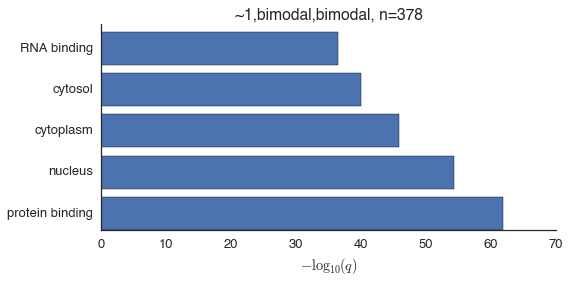

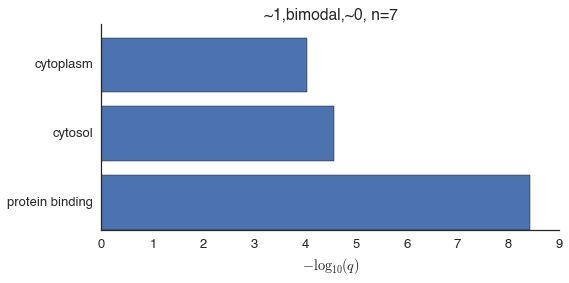

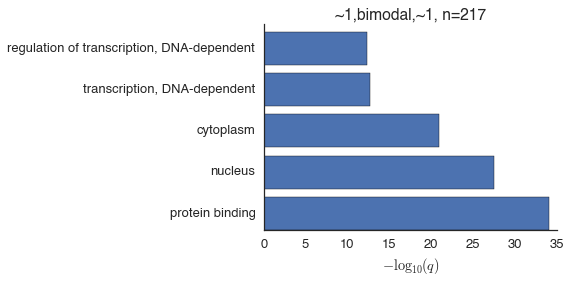

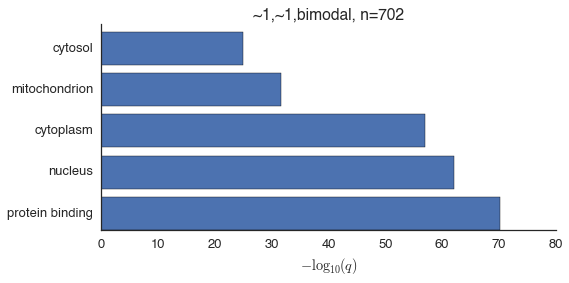

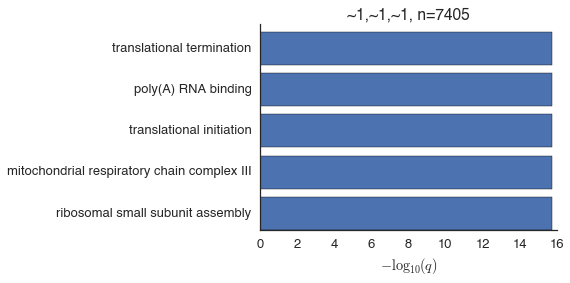

In [28]:
from flotilla.visualize.gene_ontology import plot_go_enrichment

background = study.splicing.splicing_to_expression_id(modality_across_celltypes.index)

go_dfs = []

for modalities, s in modality_across_celltypes.groupby(modality_across_celltypes):
    print modalities, s.shape
    modality_genes = study.splicing.splicing_to_expression_id(s.index)
    go = study.go_enrichment(modality_genes, background, p_value_cutoff=1)
    if go is None or go.empty:
        print '\t... empty GO enrichment!'
        continue
    fig, ax = plt.subplots(figsize=(8, 4))
    ax = plot_go_enrichment(data=go, max_categories=5)
    prefix = '{}/modality_go_enrichment_across_celltypes_{}'.format(folder, modalities)
    go.to_csv('{}.csv'.format(prefix))
    go['modalities'] = modalities
    go_dfs.append(go)
    
    print go.head()
    ax.set_title('{}, n={}'.format(modalities, s.shape[0]))
    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}.pdf'.format(prefix))
go_df = pd.concat(go_dfs)

In [ ]:
g = sns.FacetGrid(go_df_subset, row='modalities', size=2, aspect=3, 
                  row_order=relevant_modality_groups.index, sharey=False)
g.map_dataframe(plot_go_enrichment, x_col=u'bonferonni_corrected_p_value', max_categories=5, color='lightgrey')
g.set(title='')
g.fig.savefig('{}/modalities_across_celltypes_go_enrichment.pdf'.format(folder))

### Enrichment of this modality, within phenotype

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to other modalities in iPSC?"*

MN
	bimodal
	~0
	~1
NPC
	ambiguous
... empty GO enrichment!
	bimodal
	~0
	~1
iPSC
	ambiguous
	bimodal
	middle
... empty GO enrichment!
	~0
	~1


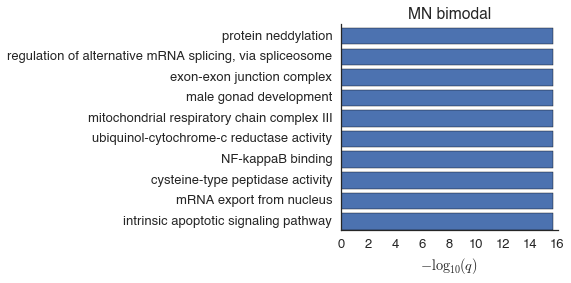

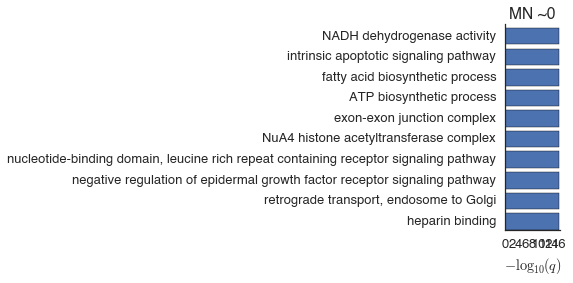

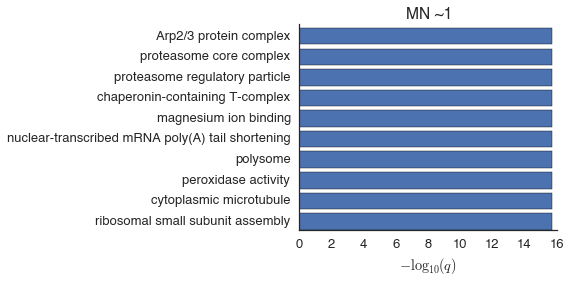

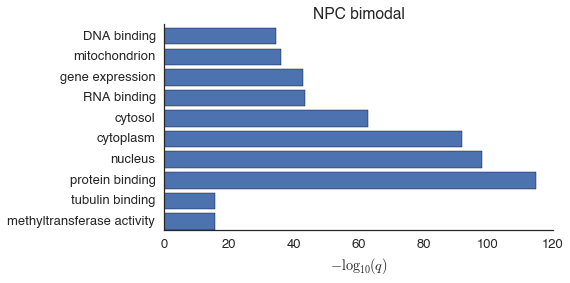

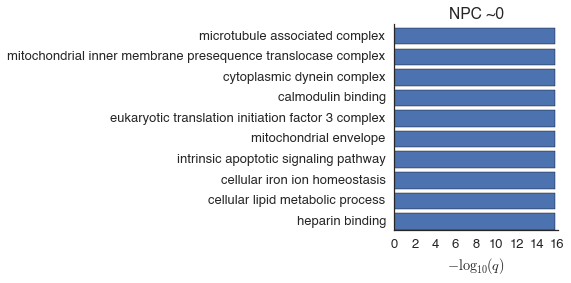

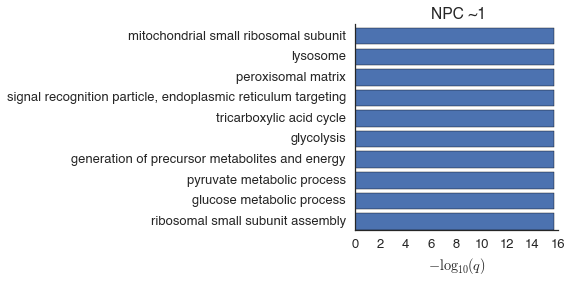

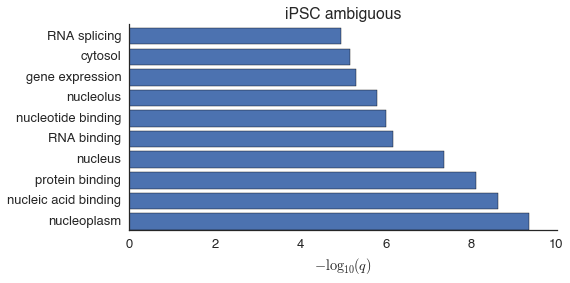

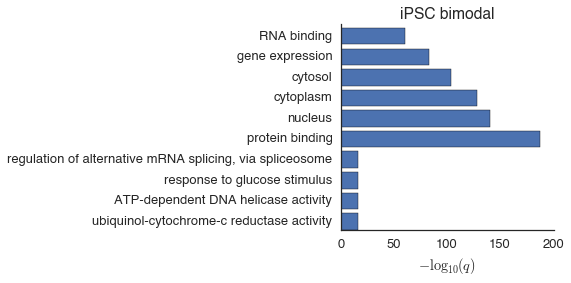

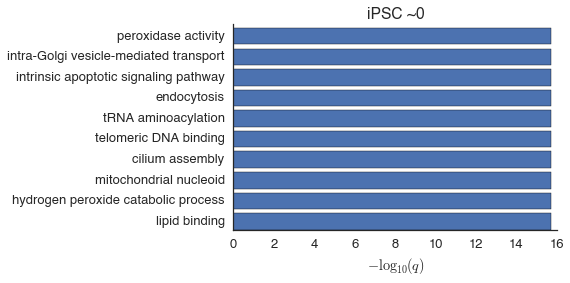

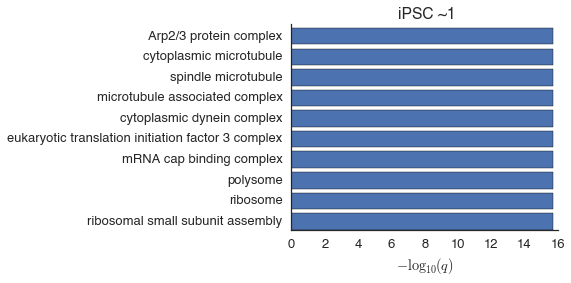

In [31]:
for (phenotype), phenotype_df in study.supplemental.modalities_tidy.groupby(['phenotype']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_name)
    for modality, modality_df in phenotype_df.groupby('modality'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_name)
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01)
        if go is None or go.empty:
            print '... empty GO enrichment!'
            continue
        fig, ax = plt.subplots(figsize=(8, 4))
        ax = plot_go_enrichment(data=go)
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
        fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_within_celltype_{}_{}.pdf'.format(folder, modality, phenotype))

### Enrichment of this modality, across phenotypes

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to bimodal events in NPC and MN?"*

ambiguous
	NPC
	... empty GO enrichment!
	iPSC
bimodal
	MN
	NPC
	iPSC
middle
	iPSC
	... empty GO enrichment!
~0
	MN
	NPC
	iPSC
~1
	MN
	NPC
	iPSC


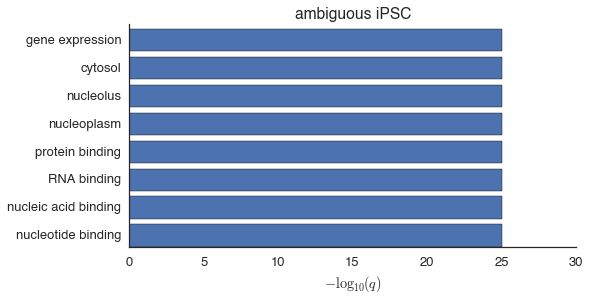

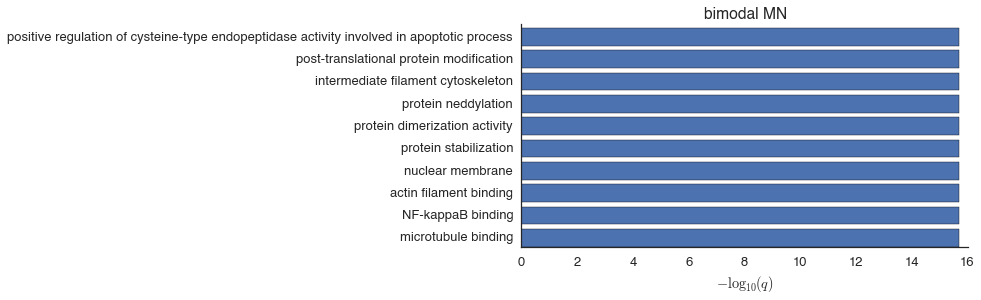

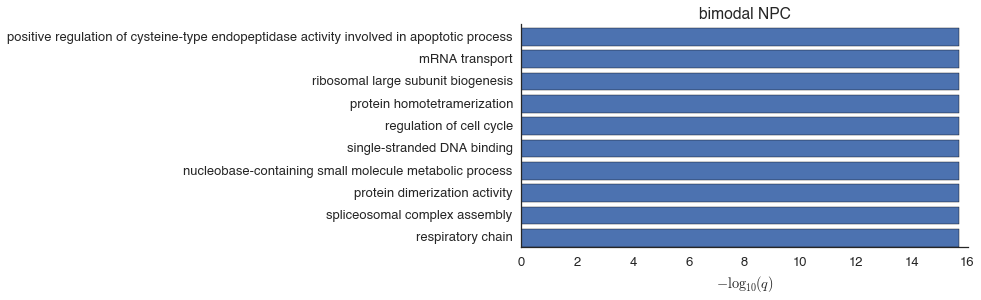

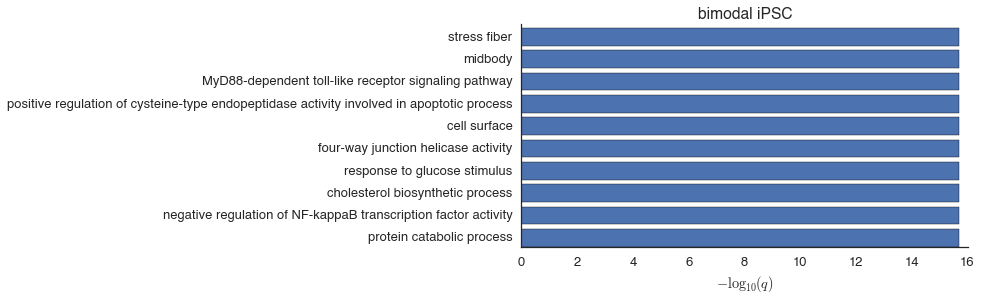

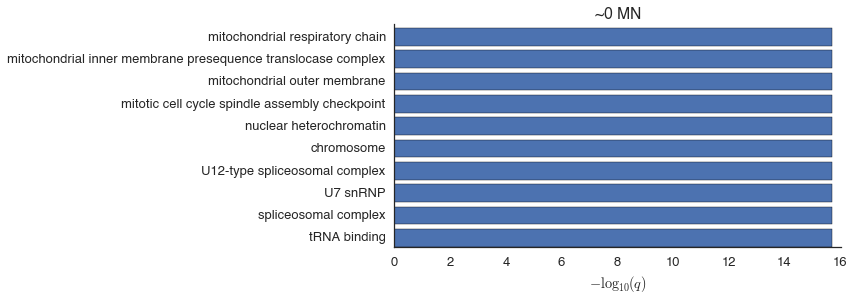

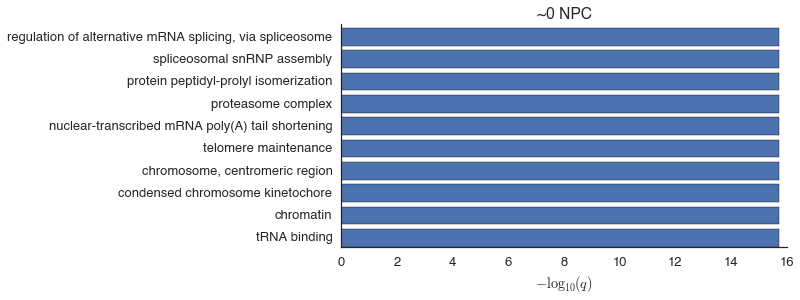

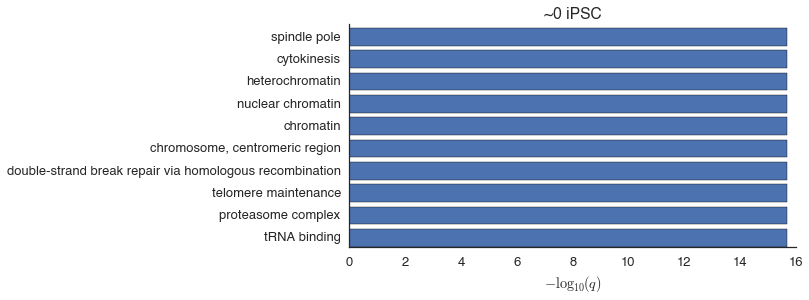

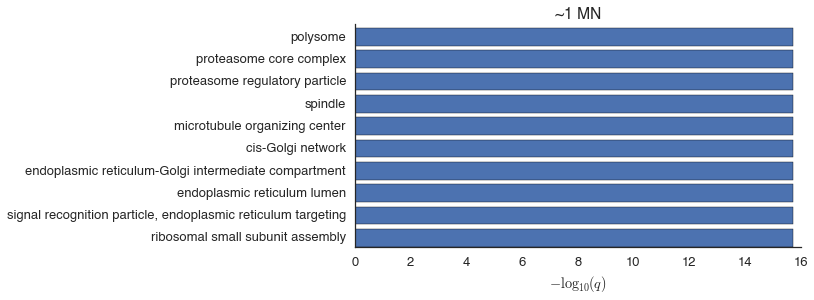

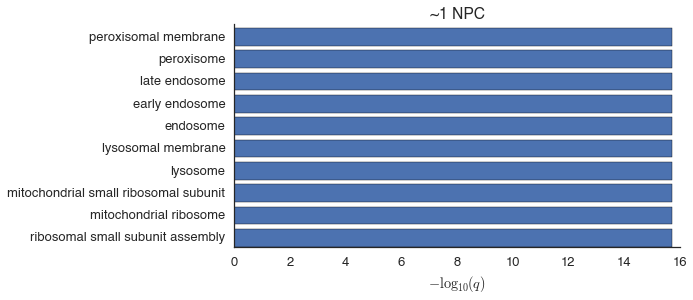

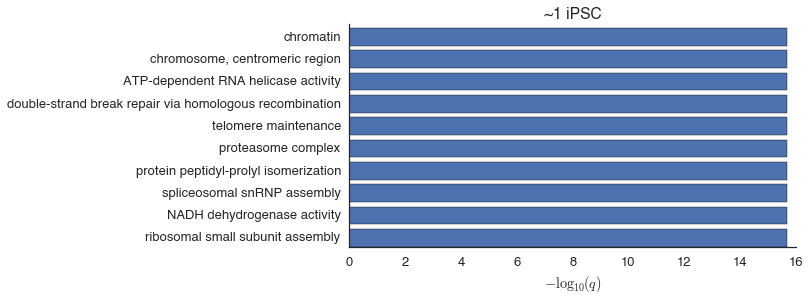

In [34]:
import itertools

modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_name').filter(
    lambda x: len(x)==len(study.phenotype_order))

for (phenotype), phenotype_df in modalities_all_celltypes.groupby(['modality']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_name)
    for modality, modality_df in phenotype_df.groupby('phenotype'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_name)
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01)
        if go is None or go.empty:
            print '\t... empty GO enrichment!'
            continue
        fig, ax = plt.subplots(figsize=(8, 4))
        ax = plot_go_enrichment(data=go)
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_across_celltypes_{}_{}.pdf'.format(folder, modality, phenotype))

### Enrichment of this modality vs all other modalities across phenotypes

i.e. *"What GO categories are bimodal events in iPSC, NPC and MN enriched for, over other modalities in those celltypes?"*

ambiguous
bimodal
middle
	... empty GO enrichment!
~0
~1


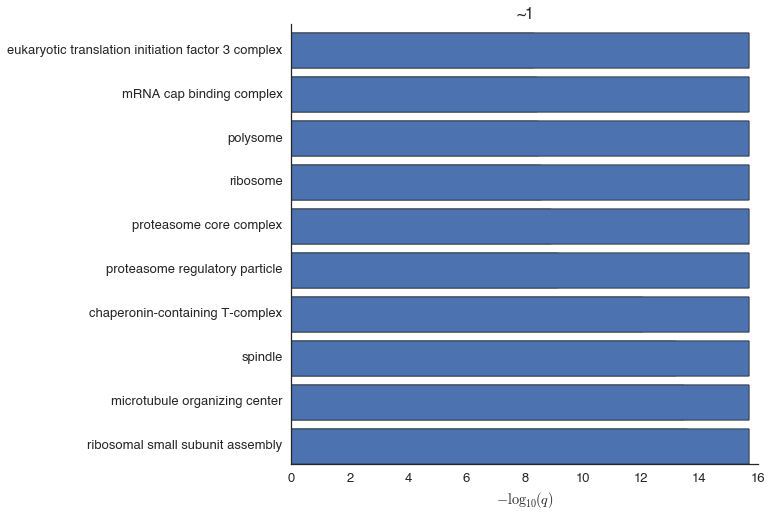

In [33]:
import itertools

background = study.splicing.splicing_to_expression_id(modalities_all_celltypes.event_name)


for (group), df1 in modalities_all_celltypes.groupby(['modality']):
    print group
    foreground = study.splicing.splicing_to_expression_id(df1.event_name)
    go = study.go_enrichment(foreground, background, p_value_cutoff=0.1)
    if go is None or go.empty:
        print '\t... empty GO enrichment!'
        continue

    ax = plot_go_enrichment(data=go)
    ax.set_title(group)
    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}/modality_go_enrichment_across_celltypes_{}.pdf'.format(folder, group))

### Enrichment of events which change (or don't change) modality



In [ ]:
changing_modalities = modalities_all_celltypes_no_constitutive.groupby('event_name').filter(
    lambda x: x.modality.unique().shape[0] > 1)

### Make bed files of modality exons

In [ ]:
%%time 
import pybedtools

bed_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/'

DIR = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

# upstream400 = pybedtools.BedTool('{}/se_mxe_alt_exon_upstream400.bed'.format(DIR))
# downstream400 = pybedtools.BedTool('{}/se_mxe_alt_exon_downstream400.bed'.format(DIR))e
exon_5p = pybedtools.BedTool('{}/exon_5p.bed'.format(DIR))
exon_3p = pybedtools.BedTool('{}/exon_3p.bed'.format(DIR))

exons = {'exon_5p': exon_5p, 'exon_3p': exon_3p}

for (phenotype, modality), df in study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']):
    event_names = set(df.event_name.values)
    for name, bed in exons.items():
        phenotype_modality_bed = bed.filter(lambda x: x.name in event_names)
        filename = '{}/{}_exonbody_{}_{}.bed'.format(bed_folder, name, phenotype, modality)
        phenotype_modality_bed.saveas(filename)
        ! wc -l $filename


In [2]:
mkdir /home/obotvinnik/projects/singlecell_pnms/analysis/homer/

mkdir: cannot create directory `/home/obotvinnik/projects/singlecell_pnms/analysis/homer/': File exists


## HOMER enrichment


In [3]:
homer_dir = '/home/obotvinnik/projects/singlecell_pnms/analysis/homer'

### First extract upstream/downstream intron sequences

In [16]:
import os
import glob
import pybedtools

nt = 400

bed_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/'

for bedfile in glob.iglob('{}/exon*p_exonbody*.bed'.format(bed_folder)):
    basename = os.path.basename(bedfile)
    print basename
    prefix = basename.split('.bed')[0]
    bed = pybedtools.BedTool(bedfile)
    
    if basename.startswith('exon_5p'):
        # Get downstream intron
        intron = bed.flank(l=0, r=nt, s=True, g=pybedtools.chromsizes('hg19'))
        name = 'downstream'
    else:
        intron = bed.flank(l=nt, r=0, s=True, g=pybedtools.chromsizes('hg19'))
        name = 'upstream'
    
    # Saved every exon that was exactly upstream or downstream of a junction,
    # So when taking the flanking sequence, there's a lot of repetition
    unique = pybedtools.BedTool(list(set(x for x in intron)))
    
    
    print '\t', len(intron), len(unique)
    saveas = '{}/{}_{}{}.bed'.format(homer_dir, prefix, name, nt)
    print '\t', saveas
    unique.saveas(saveas)

exon_5p_exonbody_MN_bimodal.bed
	30297 2480
	/home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_MN_bimodal_downstream400.bed
exon_3p_exonbody_iPSC_~0.bed
	83691 14300
	/home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonbody_iPSC_~0_upstream400.bed
exon_5p_exonbody_iPSC_~0.bed
	140881 14910
	/home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_iPSC_~0_downstream400.bed
exon_5p_exonbody_MN_ambiguous.bed
	0 0
	/home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_MN_ambiguous_downstream400.bed
exon_5p_exonbody_MN_constitutively0.bed
	88455 9375
	/home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_MN_constitutively0_downstream400.bed
exon_3p_exonbody_MN_~0.bed
	21035 3408
	/home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonbody_MN_~0_upstream400.bed
exon_3p_exonbody_iPSC_constitutively1.bed
	99526 20030
	/home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_e

### Enrichment of modality trios

#### Background:  all other modality trios


In [ ]:
import os
from gscripts.qtools import Submitter
import glob


findMotifsGenome = '/home/yeo-lab/software/homer/bin/findMotifsGenome.pl'
n_processors = 4
homer_flags = '-rna -len 4,5,6,7 -mset vertebrates -mis 1 -p {}'.format(n_processors)

commands = []


for bedfile in glob.iglob('{}/exon_*p_exonbody*.bed'.format(homer_dir)):
    if 'background' in bedfile:
        continue
    
    basename = os.path.basename(bedfile)
    prefix = basename.split('.')[0]
    modality = prefix.split('_')[4]
    if modality.startswith('constitutively'):
        continue
    
    background = bedfile.replace(modality, modality+ '_background')
    out_dir = bedfile.replace('.bed', '_vs_other_modality_trios')
    command = '{} {} hg19 {} -bg {} {}'.format(
        findMotifsGenome, bedfile, out_dir, background, homer_flags)
    print '\n', command
    commands.append(command)
#     ! $command
jobname = 'homer_vs_other_modality_trios'
sub = Submitter(commands, jobname, walltime='2:00:00', queue='home-scrm',
               ppn=n_processors, write_and_submit=True, array=True,
               out_filename='{}/{}.out'.format(homer_dir, jobname),
               err_filename='{}/{}.err'.format(homer_dir, jobname),
               )

### Enrichment of phenotype-specific modalities

#### Background: constitutively spliced exons

In [21]:
import os
from gscripts.qtools import Submitter
import glob


findMotifsGenome = '/home/yeo-lab/software/homer/bin/findMotifsGenome.pl'
n_processors = 4
homer_flags = '-rna -len 4,5,6,7 -mset vertebrates -mis 1 -p {}'.format(n_processors)

commands = []


for bedfile in glob.iglob('{}/exon_*p_exonbody*.bed'.format(homer_dir)):

    basename = os.path.basename(bedfile)
    prefix = basename.split('.')[0]
    modality = prefix.split('_')[4]
    if modality.startswith('constitutively'):
        continue
    
    background = bedfile.replace(modality, 'constitutively1')
    out_dir = bedfile.replace('.bed', '_vs_constitutively1')
    command = '{} {} hg19 {} -bg {} {}'.format(
        findMotifsGenome, bedfile, out_dir, background, homer_flags)
    print '\n', command
    commands.append(command)
#     ! $command
jobname = 'homer_vs_constitutively1'
sub = Submitter(commands, jobname, walltime='2:00:00', queue='home-scrm',
               ppn=n_processors, write_and_submit=True, array=True,
               out_filename='{}/{}.out'.format(homer_dir, jobname),
               err_filename='{}/{}.err'.format(homer_dir, jobname),
               )

running 30 tasks as an array-job.
job ID: 3133883



/home/yeo-lab/software/homer/bin/findMotifsGenome.pl /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_NPC_bimodal_downstream400.bed hg19 /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_NPC_bimodal_downstream400_vs_constitutively1 -bg /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_NPC_constitutively1_downstream400.bed -rna -len 4,5,6,7 -mset vertebrates -mis 1 -p 4

/home/yeo-lab/software/homer/bin/findMotifsGenome.pl /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonbody_NPC_~0_upstream400.bed hg19 /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonbody_NPC_~0_upstream400_vs_constitutively1 -bg /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonbody_NPC_constitutively1_upstream400.bed -rna -len 4,5,6,7 -mset vertebrates -mis 1 -p 4

/home/yeo-lab/software/homer/bin/findMotifsGenome.pl /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonb

#### Background: All other modalities, within that celltype

In [4]:
import os
import fileinput

from gscripts.qtools import Submitter
import glob
import itertools

findMotifsGenome = '/home/yeo-lab/software/homer/bin/findMotifsGenome.pl'
n_processors = 4
homer_flags = '-rna -len 4,5,6,7 -mset vertebrates -mis 1 -p {}'.format(n_processors)

commands = []


for bedfile in glob.iglob('{}/exon_*p_exonbody*.bed'.format(homer_dir)):

    basename = os.path.basename(bedfile)
    prefix = basename.split('.')[0]
    modality = prefix.split('_')[4]
    if modality.startswith('constitutively') or 'other' in basename or 'background' in basename:
        continue
    
    background = bedfile.replace(modality, modality + '_alternative_background')
    background_filenames = (x for x in glob.iglob(bedfile.replace(modality, '*'))
                           if modality not in x and 'constitutively' not in x)
    if not os.path.exists(background):
        with open(background, 'w') as f:
            for filename in background_filenames:
                with open(filename) as g:
                    for line in g:
                        f.write(line)
    
    out_dir = bedfile.replace('.bed', '_vs_alternative_background')
    if os.path.exists('{}/homerResults.html'):
        print 'Already finished {}, moving on'.format(basename)
        continue
    command = '{} {} hg19 {} -bg {} {}'.format(
        findMotifsGenome, bedfile, out_dir, background, homer_flags)
    print '\n', command
    commands.append(command)
#     ! $command
jobname = 'homer_vs_alternative_background'
sub = Submitter(commands, jobname, walltime='4:00:00', queue='home-scrm',
               ppn=n_processors, write_and_submit=True, array=True,
               out_filename='{}/{}.out'.format(homer_dir, jobname),
               err_filename='{}/{}.err'.format(homer_dir, jobname),)

running 30 tasks as an array-job.
job ID: 3156772



/home/yeo-lab/software/homer/bin/findMotifsGenome.pl /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_NPC_bimodal_downstream400.bed hg19 /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_NPC_bimodal_downstream400_vs_alternative_background -bg /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_5p_exonbody_NPC_bimodal_alternative_background_downstream400.bed -rna -len 4,5,6,7 -mset vertebrates -mis 1 -p 4

/home/yeo-lab/software/homer/bin/findMotifsGenome.pl /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonbody_NPC_~0_upstream400.bed hg19 /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonbody_NPC_~0_upstream400_vs_alternative_background -bg /home/obotvinnik/projects/singlecell_pnms/analysis/homer/exon_3p_exonbody_NPC_~0_alternative_background_upstream400.bed -rna -len 4,5,6,7 -mset vertebrates -mis 1 -p 4

/home/yeo-lab/software/homer/bin/findMotifsGenome.pl /home/obotvinnik/projects/singl